# Northing Wind Trading Co.

## Hypothesis:

1. 
1. 
1. 

## SQL Queries Using SqLite3
### Northwind ERD
<img src='northwind_ERD.png'>

### Importing sqlite database

In [1]:
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

### List of Tables

In [2]:
c.execute('''
SELECT name
FROM sqlite_master
WHERE type='table';
''').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

## SQL for EDA
List of the columns in OrderDetail

In [3]:
c.execute('''
PRAGMA table_info(OrderDetail)
''').fetchall()

[(0, 'Id', 'VARCHAR(8000)', 0, None, 1),
 (1, 'OrderId', 'INTEGER', 1, None, 0),
 (2, 'ProductId', 'INTEGER', 1, None, 0),
 (3, 'UnitPrice', 'DECIMAL', 1, None, 0),
 (4, 'Quantity', 'INTEGER', 1, None, 0),
 (5, 'Discount', 'DOUBLE', 1, None, 0)]

SQL has some native functions that can be used for EDA, which we will explor here. The following function that we will be using will be:

* Min
* Max
* Average

In [4]:
c.execute('''
SELECT Discount, COUNT(Discount)
FROM OrderDetail
GROUP BY Discount
ORDER BY Discount;
''').fetchall()

[(0.0, 1317),
 (0.01, 1),
 (0.02, 2),
 (0.03, 3),
 (0.04, 1),
 (0.05, 185),
 (0.06, 1),
 (0.1, 173),
 (0.15, 157),
 (0.2, 161),
 (0.25, 154)]

In [5]:
c.execute('''
SELECT AVG(Discount)
FROM OrderDetail;
''').fetchall()

[(0.05616705336426916,)]

The average discount per order is 6%, but looking at the orders. As there is no native median function is SQL we will do the remaining EDA using Pandas and Numpy.

## Importing Pandas & Numpy for EDA

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
orders = pd.read_sql_query('''
SELECT *
FROM OrderDetail;
''', conn)

In [8]:
orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [9]:
orders.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [10]:
orders.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


### Visual EDA Using Matplotlib & Seaborn

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [12]:
discount = orders['Discount']
quantity = orders['Quantity']

### Histograms

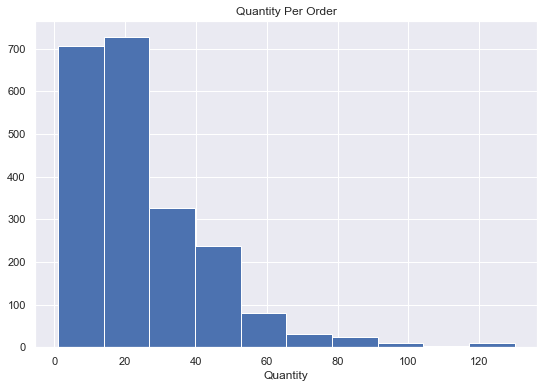

In [13]:
_ = plt.figure(figsize=(9,6))
_ = plt.hist(orders['Quantity'], bins=10)
_ = plt.title('Quantity Per Order')
_ = plt.xlabel('Quantity')
plt.show()

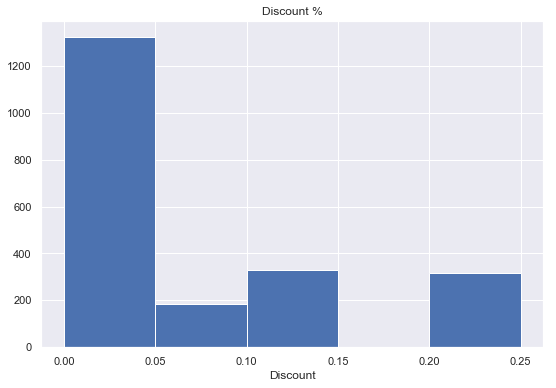

In [14]:
_ = plt.figure(figsize=(9,6))
_ = plt.hist(orders['Discount'], bins=5)
_ = plt.title('Discount %')
_ = plt.xlabel('Discount')
plt.show()

### Bee Swarm Plot

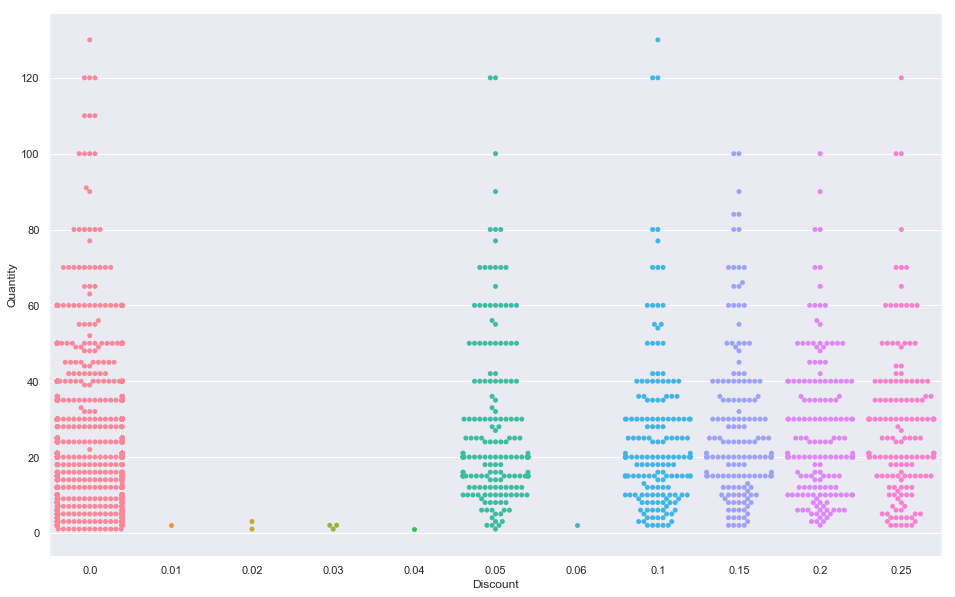

In [15]:
sns.set()
plt.figure(figsize=(16,10))
sns.swarmplot(x=orders['Discount'], y=orders['Quantity'])
plt.show()

### CDFS

In [16]:
def ecdf(data):
    '''
    Computes the ECDF for a given dataset.
    
    data: a list or array.
    
    returns: x, y
    '''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    
    return x, y

In [17]:
quantity_x, quantity_y = ecdf(quantity)

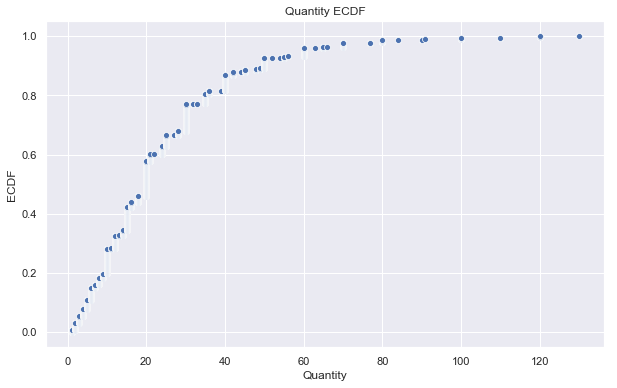

In [18]:
_ = plt.figure(figsize=(10,6))
_ = sns.scatterplot(x=quantity_x, y=quantity_y)
_ = plt.title('Quantity ECDF')
_ = plt.xlabel('Quantity')
_ = plt.ylabel('ECDF')

plt.show()

In [19]:
discount_x, discount_y = ecdf(discount)

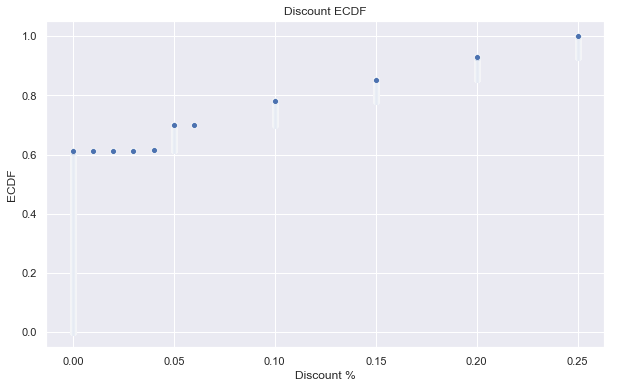

In [20]:
_ = plt.figure(figsize=(10,6))
_ = sns.scatterplot(x=discount_x, y=discount_y)
_ = plt.title('Discount ECDF')
_ = plt.xlabel('Discount %')
_ = plt.ylabel('ECDF')

plt.show()

### Box Plots

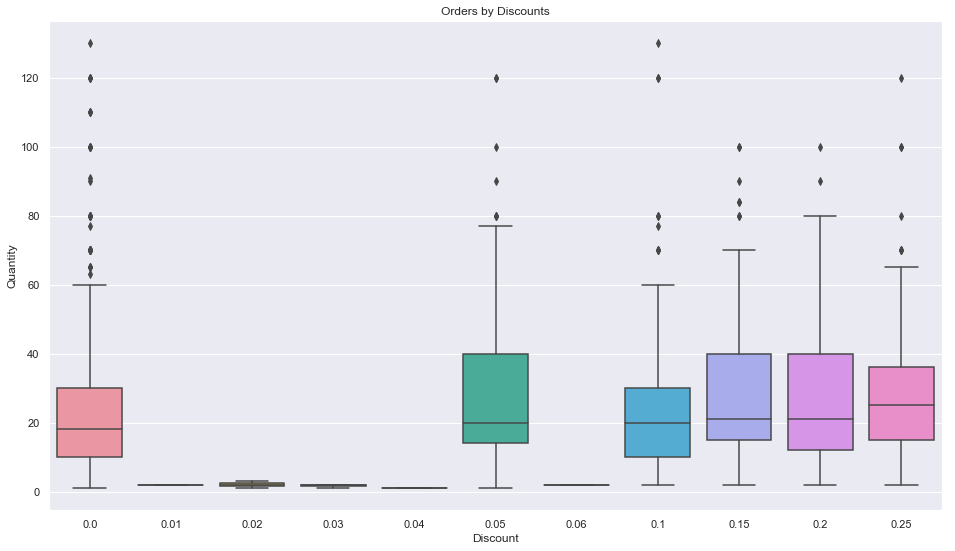

In [21]:
_ = plt.figure(figsize=(16,9))
_ = sns.boxplot(x=discount, y=quantity)
_ = plt.title('Orders by Discounts')
plt.show()

Judging from the data, if the discount is an increment of 5% the quantities ordered are more. Now let's take a look at discounts as booleans(Discount or No Discount)

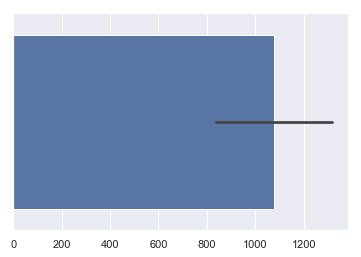

In [35]:
discount_false = len(discount[discount == 0.00])
discount_true = len(discount[discount > 0.00])
sns.barplot(pd.DataFrame([discount_false, discount_true]))